## Time Series Mini Project

The goal of this project is to discover trends in weather data from a Kaggle dataset and to forecast future temperature values. 

I chose the state of Texas to analyze, with 2325 observations from the years 1820 to 2013. I removed all columns except average temperature and converted the temperature to Fahrenheit. I dropped the data for 2013, so that there were complete years from January 1820 to December 2012. The data was split into train, validate, and test for initial modeling. The data was resplit into train and test for a 3-year previous cycle model.

Exploration of the data, resampled for 20-year intervals, shows an upward trend in average temperature over time.

I attempted to forecast using the last recorded temperature, the single average temperature, a rolling average, and Holt's linear trend. These models were not able to capture the seasonality of the data and the RMSE was between 13 and 48 degrees for these models.

The three-year previous cycle model performed best on the test set, with an RMSE of 3.48 degrees.

### Acquisition and Preparation

- load imports
- acquire the dataset
- prepare the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# save csv dataset as a pandas dataframe
df = pd.read_csv('landtemp_state.csv')

In [3]:
# confirm appropriate data
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [4]:
# prepare the data using the prep_data function from wrangle.py
df = wrangle.prep_data()

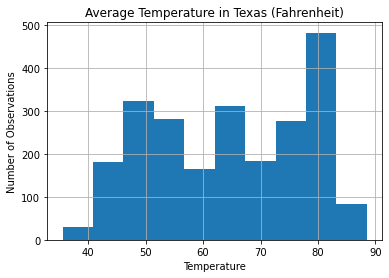

In [5]:
# visualize the data in a histogram
df.hist()
plt.xlabel('Temperature')
plt.ylabel('Number of Observations')
plt.title('Average Temperature in Texas (Fahrenheit)')
plt.show()

### Exploration

In [6]:
# split the data using a 50/30/20 split function
train, validate, test = wrangle.split_data(df)

In [7]:
# confirm correct splitting
train.size, validate.size, test.size

(1158, 694, 464)

In [8]:
# confirm no data was lost from the split
df.size == train.size + validate.size + test.size

True

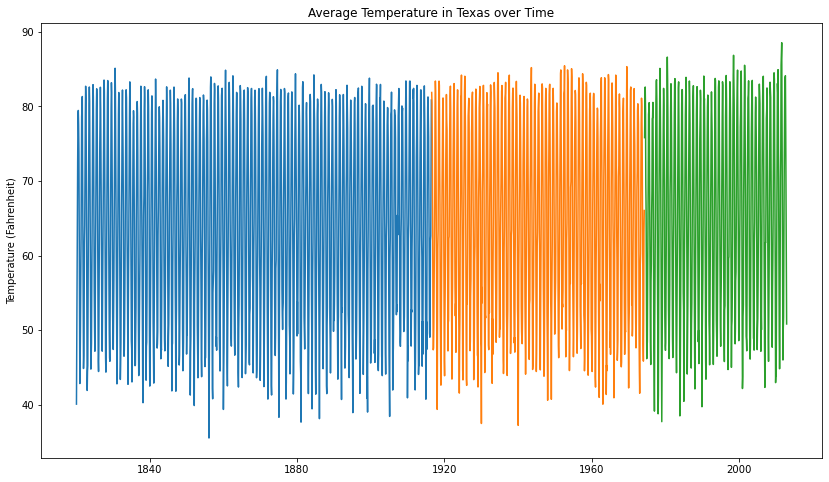

In [9]:
# plot the split datasets
wrangle.plot_data(df, train, validate, test)

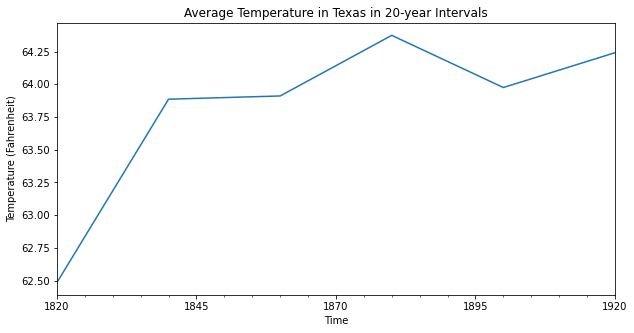

In [10]:
# plot the temperature change over 20-year intervals
plt.figure(figsize=[10,5])
# resample datetime index to 20 years
train.avg_temp.resample('20y').mean().plot()
# label x-axis
plt.xlabel('Time')
# label y-axis
plt.ylabel('Temperature (Fahrenheit)')
# add title
plt.title('Average Temperature in Texas in 20-year Intervals')
plt.show()

(5.0, 10.0)

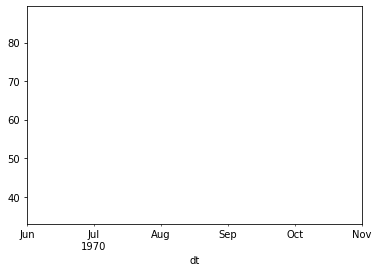

In [53]:
train.avg_temp.resample('m').plot()
plt.xlim([5,10])

#### Exploration takeaways

- Noticeable upward trend in average temperature over the last 200 years
- Seasonality noted for year-long periods

### Forecasting

#### Last Recorded Value Forecast

In [11]:
# assign last recorded temperature in train set to a variable
temp = train['avg_temp'][-1:][0]

In [12]:
# create a dataframe of predicted values using the last recorded value in train
yhat_df = pd.DataFrame({'avg_temp': [temp]},index=validate.index)
yhat_df.head()

,avg_temp
dt,
1916-07-31,80.8412
1916-08-31,80.8412
1916-09-30,80.8412
1916-10-31,80.8412
1916-11-30,80.8412


avg_temp -- RMSE: 21


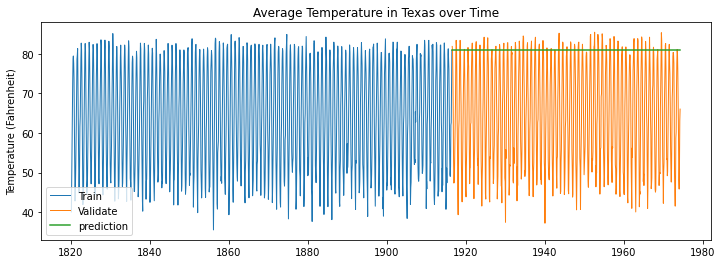

In [13]:
# plot the last recorded value prediction
wrangle.plot_and_eval('avg_temp', train, validate, yhat_df)

In [14]:
# create a dataframe with the rmse for the model
eval_df = wrangle.append_eval_df('last_observed', 'avg_temp', validate, yhat_df)
eval_df

,model_type,target_var,rmse
0,last_observed,avg_temp,21.0


#### Single Average Forecast

In [15]:
# assign the average temp to a variable
temp = train['avg_temp'].mean()

In [16]:
def make_predictions(temp=None):
    yhat_df = pd.DataFrame({'avg_temp': [temp]},
                          index=validate.index)
    return yhat_df

In [17]:
yhat_df = make_predictions(temp)

In [18]:
yhat_df.head(3)

,avg_temp
dt,
1916-07-31,64.053394
1916-08-31,64.053394
1916-09-30,64.053394


avg_temp -- RMSE: 13


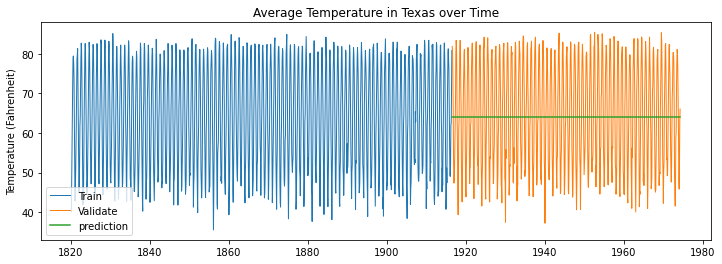

In [19]:
wrangle.plot_and_eval('avg_temp', train, validate, yhat_df)

In [20]:
eval_df2 = wrangle.append_eval_df('simple_average', 'avg_temp', validate, yhat_df)


In [21]:
eval_df = pd.concat([eval_df, eval_df2], ignore_index=True)
eval_df

,model_type,target_var,rmse
0,last_observed,avg_temp,21.0
1,simple_average,avg_temp,13.0


#### 3-year Moving Average Forecast

In [22]:
period = 36

# take 36 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temp = round(train['avg_temp'].rolling(period).mean()[-1], 2)
print(temp)

64.32


In [23]:
yhat_df = make_predictions(temp)
yhat_df.head()

,avg_temp
dt,
1916-07-31,64.32
1916-08-31,64.32
1916-09-30,64.32
1916-10-31,64.32
1916-11-30,64.32


avg_temp -- RMSE: 13


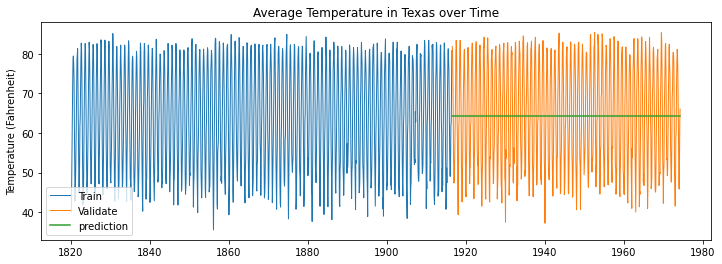

In [24]:
wrangle.plot_and_eval('avg_temp', train, validate, yhat_df)

In [25]:
eval_df3 = wrangle.append_eval_df('3y_moving_avg', 'avg_temp', validate, yhat_df)
eval_df = pd.concat([eval_df, eval_df3], ignore_index=True)

In [26]:
eval_df

,model_type,target_var,rmse
0,last_observed,avg_temp,21.0
1,simple_average,avg_temp,13.0
2,3y_moving_avg,avg_temp,13.0


#### Rolling Average Forecast

In [27]:
p = 12
temp = train['avg_temp'].rolling(p).mean()[-1]
yhat_df = make_predictions(temp)
model_type = str(p) + '_month_moving_avg'
eval_df4 = wrangle.append_eval_df('12_month_rolling_avg','avg_temp', validate, yhat_df)

In [28]:
eval_df = pd.concat([eval_df, eval_df4], ignore_index=True)

In [29]:
p = 60
temp = train['avg_temp'].rolling(p).mean()[-1]
yhat_df = make_predictions(temp)
model_type = str(p) + '_month_moving_avg'
eval_df5 = wrangle.append_eval_df('60_month_rolling_avg','avg_temp', validate, yhat_df)

In [30]:
eval_df = pd.concat([eval_df, eval_df5], ignore_index=True)
eval_df

,model_type,target_var,rmse
0,last_observed,avg_temp,21.0
1,simple_average,avg_temp,13.0
2,3y_moving_avg,avg_temp,13.0
3,12_month_rolling_avg,avg_temp,13.0
4,60_month_rolling_avg,avg_temp,13.0


#### Holt's Linear Trend Forecast

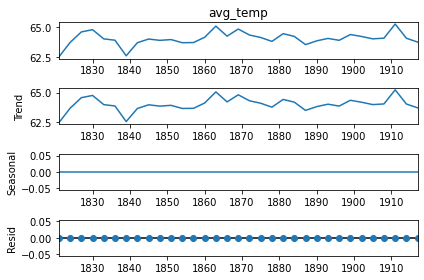

In [31]:
sm.tsa.seasonal_decompose(train.avg_temp.resample('3y').mean()).plot()
plt.show()

In [32]:
col = 'avg_temp' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped_trend=True)

In [33]:
model = model.fit(optimized=True)

In [34]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [35]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_trend = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

avg_temp -- RMSE: 49


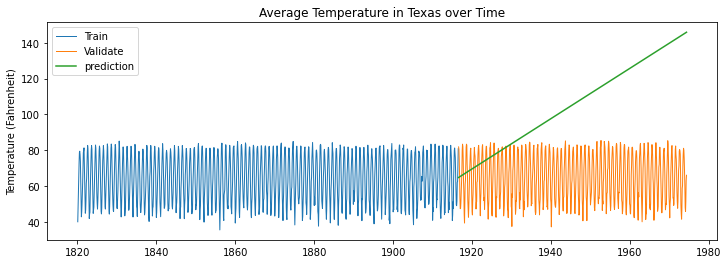

In [36]:
wrangle.plot_and_eval('avg_temp', train, validate, yhat_df)

#### Previous Cycle Forecast

In [37]:
train = df.loc[:'2009']
test = df.loc['2010':'2012']

print(train.shape)
print(test.shape)

train.head()
train.tail()


(2280, 1)
(36, 1)


,avg_temp
dt,
2009-08-31,83.6366
2009-09-30,74.5826
2009-10-31,64.1552
2009-11-30,57.4628
2009-12-31,42.9620


In [38]:
test.head()

,avg_temp
dt,
2010-01-31,44.1464
2010-02-28,43.8962
2010-03-31,54.9338
2010-04-30,65.2226
2010-05-31,74.1344


In [39]:
pd.concat([train.tail(1), test.head(1)])

,avg_temp
dt,
2009-12-31,42.9620
2010-01-31,44.1464


In [40]:
train.diff(36).mean()

avg_temp    0.034623
dtype: float64

In [41]:
yhat_df = df.loc['2007':'2009'] + train.diff(36).mean()

In [48]:
yhat_df.head(3)

,avg_temp
dt,
2010-01-31,42.355823
2010-02-28,49.192223
2010-03-31,61.801223


In [43]:
yhat_df.index = test.index

<AxesSubplot:xlabel='dt'>

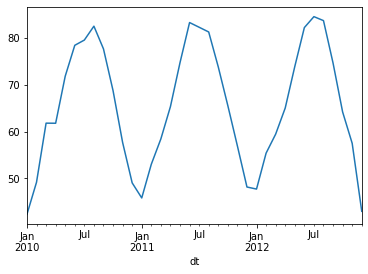

In [44]:
yhat_df.avg_temp.resample('m').mean().plot()

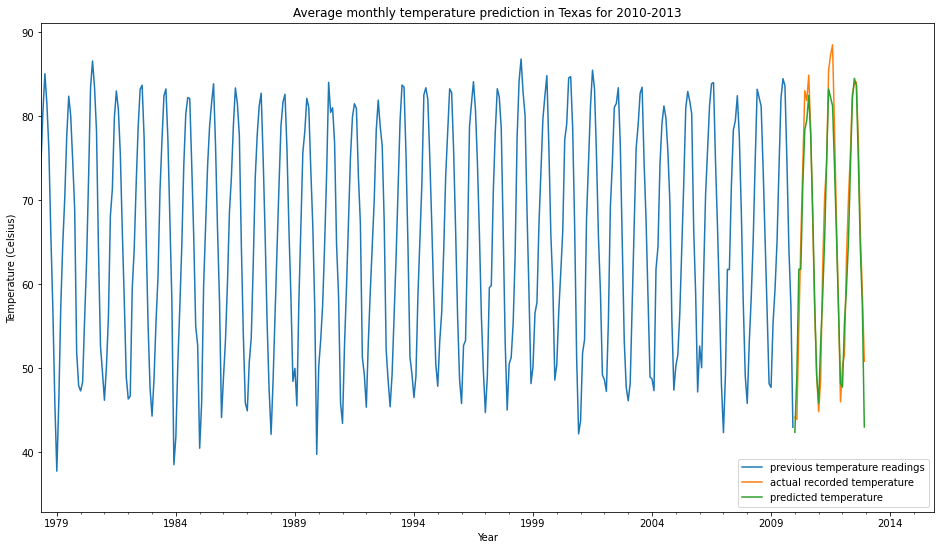

In [45]:
plt.figure(figsize=[16,9])
train.avg_temp.resample('m').mean().plot(label='previous temperature readings')
test.avg_temp.resample('m').mean().plot(label='actual recorded temperature')
yhat_df.avg_temp.resample('m').mean().plot(label='predicted temperature')
plt.xlim([100,550])
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Average monthly temperature prediction in Texas for 2010-2013')
plt.legend()

In [46]:
rmse_temp = sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp']))

In [47]:
rmse_temp

3.482276241466225

#### Forecasting takeaways:

- None of the models performed well in predicting future temperatures, with the exception of the previous cycle model.
- The previous cycle model was able to capture seasonality over a three-year period and predicted future temperatures with an RMSE of 3.48 degrees.